<a href="https://colab.research.google.com/github/ridhimagarg/PyTorchBook/blob/main/Chapter04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, RandomHorizontalFlip, Resize

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

# from data_generation.image_classification import generate_dataset
from image_classification import generate_dataset ##  if working on  colab 
from v0 import StepByStep
# from plot.chapter4 import * 
from chapter4 import *
# from stepbystep.v0 import StepByStep




## Data Generation

In [2]:
## lets generate 300
images, labels = generate_dataset(img_size=5, n_images=300, seed=13)

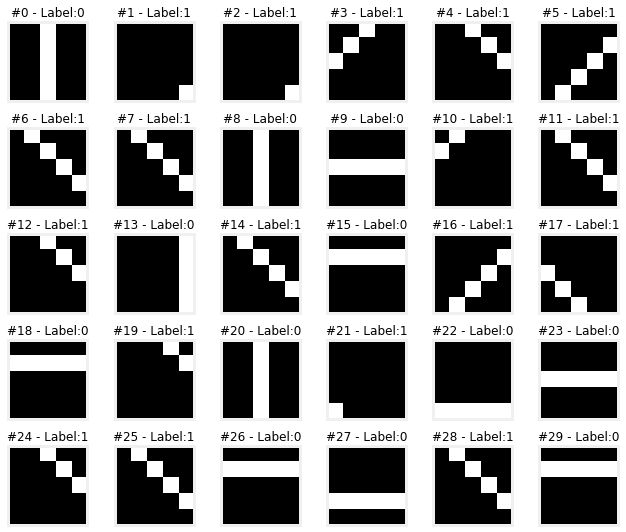

In [3]:
fig = plot_images(images, labels, n_plot=30)

In [4]:
## Images  and channels

image_r = np.zeros((5, 5), dtype=np.uint8)
image_r[:, 0] = 255
image_r[:, 1] = 128
image_g = np.zeros((5, 5), dtype=np.uint8)
image_g[:, 1] = 128
image_g[:, 2] = 255
image_g[:, 3] = 128
image_b = np.zeros((5, 5), dtype=np.uint8)
image_b[:, 3] = 128
image_b[:, 4] = 255

In [5]:
image_r

array([[255, 128,   0,   0,   0],
       [255, 128,   0,   0,   0],
       [255, 128,   0,   0,   0],
       [255, 128,   0,   0,   0],
       [255, 128,   0,   0,   0]], dtype=uint8)

In [6]:
image_g

array([[  0, 128, 255, 128,   0],
       [  0, 128, 255, 128,   0],
       [  0, 128, 255, 128,   0],
       [  0, 128, 255, 128,   0],
       [  0, 128, 255, 128,   0]], dtype=uint8)

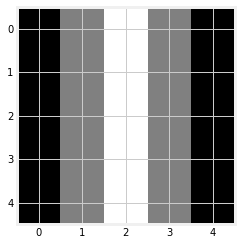

In [7]:
plt.imshow(image_g, cmap="gray")
plt.show()

In [8]:
image_rgb = np.stack([image_r, image_g, image_b], axis=2)
print(image_rgb)

[[[255   0   0]
  [128 128   0]
  [  0 255   0]
  [  0 128 128]
  [  0   0 255]]

 [[255   0   0]
  [128 128   0]
  [  0 255   0]
  [  0 128 128]
  [  0   0 255]]

 [[255   0   0]
  [128 128   0]
  [  0 255   0]
  [  0 128 128]
  [  0   0 255]]

 [[255   0   0]
  [128 128   0]
  [  0 255   0]
  [  0 128 128]
  [  0   0 255]]

 [[255   0   0]
  [128 128   0]
  [  0 255   0]
  [  0 128 128]
  [  0   0 255]]]


In [9]:
images.shape

(300, 1, 5, 5)

In [10]:
example = images[7]

In [11]:
example

array([[[  0, 255,   0,   0,   0],
        [  0,   0, 255,   0,   0],
        [  0,   0,   0, 255,   0],
        [  0,   0,   0,   0, 255],
        [  0,   0,   0,   0,   0]]], dtype=uint8)

In [12]:
## In pytorch, we use channels, height, width
## so for PIL, we have to transpose to height, width, channels.
example_hwc = np.transpose(example, (1, 2, 0))
example_hwc.shape


(5, 5, 1)

In [13]:
## Converting the nump array to pytorch array.
tensorizer = ToTensor()
example_tensor = tensorizer(example_hwc)
example_tensor.shape

torch.Size([1, 5, 5])

In [14]:
example_tensor
## this time value is not 255, may be totensor changes the scale range

tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])

In [15]:
## To visualize the images, lets convert it to PIL Image

example_img = ToPILImage()(example_tensor)
print(type(example_img))

<class 'PIL.Image.Image'>


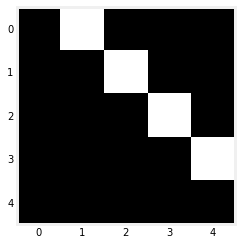

In [16]:
plt.imshow(example_img, cmap="gray")
plt.grid(False)

## Transform images

In [17]:
flipper = RandomHorizontalFlip(p=1.0)
flipped_img = flipper(example_img)

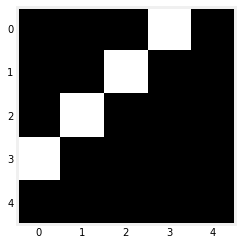

In [18]:
plt.imshow(flipped_img, cmap="gray")
plt.grid(False)

In [19]:
## Lets convert the flipped image into tensor first

In [20]:
img_tensor = tensorizer(flipped_img)
img_tensor

tensor([[[0., 0., 0., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])

In [21]:
## Min max scaler using 0.5 as mean and std deviation

normalizer = Normalize(mean=(.5,), std=(.5,))
normalized_tensor = normalizer(img_tensor)
normalized_tensor


tensor([[[-1., -1., -1.,  1., -1.],
         [-1., -1.,  1., -1., -1.],
         [-1.,  1., -1., -1., -1.],
         [ 1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.]]])

## Composing Transforms

In [22]:
composer = Compose([RandomHorizontalFlip(p=1.0),
                    Normalize(mean=(.5,), std=(.5,))])

In [23]:
composed_tensor = composer(example_tensor)
(composed_tensor == normalized_tensor).all()

tensor(True)

In [24]:
## As we can see we have used the transformed Pytorch tensor, we didnt used the the original pytorch tensor.

print(example) ## original tensor
print(example_tensor) ## transformed tensor /33 and we are using this while transformations/augmentation

[[[  0 255   0   0   0]
  [  0   0 255   0   0]
  [  0   0   0 255   0]
  [  0   0   0   0 255]
  [  0   0   0   0   0]]]
tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])


In [25]:
## Simple conversion so will follow this.
example_tensor = torch.as_tensor(example / 255).float()

## Data Preparation

In [26]:
x_tensor = torch.as_tensor(images/255).float()
y_tensor = torch.as_tensor(labels.reshape(-1,1)).float()
# The only difference is that we scaled the images to get them into the expected [0.0,1.0] range

In [27]:
## LEts build dataset not like TensorDataset like before but using custom dataset

In [28]:
class TransformedTensorDataset(Dataset):
  def __init__(self, x, y, transform=None):
    self.x = x
    self.y = y
    self.transform = transform

  def __getitem__(self, index):
      x = self.x[index]

      if self.transform:
        x = self.transform(x)

      return x, self.y[index]

  def __len__(self):
    return len(self.x)

In [29]:
## Lets redefine the compose

composer = Compose([RandomHorizontalFlip(p=1.0),
                    Normalize(mean=(.5,), std=(.5,))])

dataset = TransformedTensorDataset(x_tensor, y_tensor, composer)

In [30]:
## Now we will split our dataset but using different sampler, SubsetRandomSampler

def index_splitter(n, splits, seed=13):
  idx = torch.arange(n)

  splits_tensor = torch.as_tensor(splits)

  multiplier = n / splits_tensor.sum()
  print(multiplier)
  splits_tensor = (multiplier * splits_tensor).long()
  print(splits_tensor)
  # If there is a difference, throws at the first split
  10 # so random_split does not complain
  ## not very clear
  diff = n - splits_tensor.sum()
  print(diff)

  splits_tensor[0] += diff

  torch.manual_seed(seed)
  return random_split(idx, splits_tensor)

In [31]:
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
train_idx


tensor(3.)
tensor([240,  60])
tensor(0)


In [32]:
train_idx.indices

[118,
 170,
 148,
 239,
 226,
 146,
 168,
 195,
 6,
 180,
 157,
 2,
 160,
 66,
 46,
 276,
 126,
 212,
 119,
 77,
 53,
 237,
 252,
 202,
 200,
 289,
 135,
 186,
 231,
 211,
 35,
 293,
 229,
 265,
 256,
 134,
 191,
 214,
 8,
 83,
 150,
 190,
 208,
 209,
 275,
 60,
 295,
 142,
 251,
 176,
 260,
 3,
 31,
 0,
 137,
 20,
 81,
 287,
 181,
 129,
 166,
 97,
 110,
 206,
 267,
 241,
 109,
 177,
 27,
 52,
 43,
 245,
 247,
 141,
 68,
 131,
 217,
 78,
 185,
 49,
 96,
 14,
 111,
 234,
 284,
 263,
 269,
 101,
 32,
 285,
 79,
 297,
 94,
 85,
 11,
 5,
 80,
 165,
 183,
 4,
 33,
 100,
 73,
 235,
 277,
 16,
 144,
 132,
 167,
 130,
 45,
 48,
 201,
 99,
 34,
 138,
 178,
 244,
 225,
 173,
 95,
 22,
 197,
 174,
 90,
 223,
 274,
 92,
 279,
 19,
 74,
 28,
 162,
 133,
 151,
 37,
 299,
 18,
 203,
 13,
 156,
 268,
 259,
 116,
 70,
 71,
 230,
 108,
 238,
 47,
 163,
 30,
 188,
 64,
 216,
 121,
 187,
 72,
 221,
 258,
 44,
 179,
 272,
 159,
 253,
 280,
 140,
 120,
 62,
 271,
 57,
 1,
 149,
 9,
 29,
 194,
 158,
 115,
 1

In [33]:
## Now used the sampler

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [34]:
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]


In [35]:
train_composer = Compose([RandomHorizontalFlip(p=.5),
                          Normalize(mean=(.5,), std=(.5,))])

val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

In [36]:
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)


In [37]:
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

## Weighted Random Sampler

In [38]:
classes, counts = y_train_tensor.unique(return_counts= True)
print(classes, counts, )

tensor([0., 1.]) tensor([ 80, 160])


In [39]:
weights = 1.0/ counts.float()
print(weights)

tensor([0.0125, 0.0063])


In [40]:
## Here in pytorch it is not sufficient to give weights to classes but we have to assign weight to each data point
sample_weights = weights[y_train_tensor.squeeze().long()]


print(sample_weights.shape) ## this way we have assigned the weight to each data point
print(sample_weights[:10])
print(y_train_tensor[:10].squeeze().long())

torch.Size([240])
tensor([0.0063, 0.0063, 0.0063, 0.0063, 0.0063, 0.0125, 0.0063, 0.0063, 0.0063,
        0.0063])
tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1])


In [41]:
## Lets create a sampler

generator = torch.Generator()

sampler = WeightedRandomSampler(
    weights= sample_weights,
    num_samples = len(sample_weights),
    generator = generator,
    replacement= True
)

## We will set the seed in the generator later on.. first creates the data loader

train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)

val_loader = DataLoader(dataset=val_dataset, batch_size=16, )

In [42]:
## Lets create a helper function

def make_balanced_sampler(y):

  classes, counts = y.unique(return_counts=True)
  weights = 1.0/counts.float()
  sample_weights = weights[y.squeeze().long()]

  generator = torch.Generator()

  sampler = WeightedRandomSampler(
      weights = sample_weights,
      num_samples = len(sample_weights),
      generator = generator,
      replacement = True
  )
  return sampler

In [43]:
sampler = make_balanced_sampler(y_train_tensor)

In [44]:
## Time to set the seed
train_loader.sampler.generator.manual_seed(42)
random.seed(42) ## Why we have this extra seed, as this is for python random module, after pytorch 0.8 some of the transformation is using this.

In [45]:
## Now lets check how many +ve data points we have
## iter(train_loader) is giving the next batch.
torch.tensor([t[1].sum() for t in iter(train_loader)]).sum()

## Conclusion is now we have 123 images of +ve classes, hence we have oversampled the -ve classes which is good.
## Now e have a balanced dataset

tensor(123.)

In [46]:
len([t[1].sum() for t in iter(train_loader)])

15

In [47]:
[t[1].sum() for t in iter(train_loader)]

[tensor(7.),
 tensor(3.),
 tensor(8.),
 tensor(6.),
 tensor(11.),
 tensor(7.),
 tensor(7.),
 tensor(8.),
 tensor(9.),
 tensor(4.),
 tensor(9.),
 tensor(3.),
 tensor(7.),
 tensor(8.),
 tensor(9.)]

In [48]:
from inspect import Attribute
## Lets update our stepbystep set_seed method

def set_seed(self, seed=42):
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)
  try:
    self.train_loader.sampler.generator.manual_seed(seed)
  except AttributeError:
    pass

  setattr(StepByStep, 'set_seed', set_seed)

## Putting all together

In [49]:
## Build tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(images/255).float()
y_tensor = torch.as_tensor(labels.reshape(-1,1)).float()

## Uses index_splitter to generate indices
train_idx, val_idx = index_splitter(len(x_tensor), [80,20])

## Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# Buils different composers because of data augmentation on training set
train_composer = Compose([RandomHorizontalFlip(p=0.5),
                         Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5), std=(.5,))])

train_dataset = TransformedTensorDataset(
    x_train_tensor, y_train_tensor, transform=train_composer
)

val_dataset = TransformedTensorDataset(
    x_val_tensor, y_val_tensor, transform=val_composer
)

## Builds weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

train_loader = DataLoader(
    dataset=train_dataset, batch_size=16, sampler=sampler
)

val_loader = DataLoader(dataset=val_dataset, batch_size=16)

tensor(3.)
tensor([240,  60])
tensor(0)


### All done with data preparation

## Pixels as Features

In [50]:
## Lets try flattening up the each pixel

dummy_xs, dummy_ys = next(iter(train_loader))
dummy_xs.shape

torch.Size([16, 1, 5, 5])

In [51]:
flattener = nn.Flatten()
dummy_xs_flat = flattener(dummy_xs)

print(dummy_xs_flat.shape)
print(dummy_xs_flat[0])

torch.Size([16, 25])
tensor([-1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1.,
        -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1.])


## Shallow Model

## Model Configuration

In [52]:
lr= 0.1

torch.manual_seed(17)
# Now we can create a model

model_logistic = nn.Sequential()
model_logistic.add_module('flatten', nn.Flatten())
model_logistic.add_module('output', nn.Linear(25, 1, bias=False))
model_logistic.add_module('sigmoid', nn.Sigmoid())

## Defines a SGD optimizer to update the parameters
optimizer_logistic = optim.SGD(
    model_logistic.parameters(), lr=lr
)

binary_loss_fn = nn.BCELoss()

## Model Training

In [53]:
n_epochs = 100

sbs_logistic = StepByStep(
    model_logistic, binary_loss_fn, optimizer_logistic
)

sbs_logistic.set_loaders(train_loader, val_loader)
sbs_logistic.train(n_epochs)

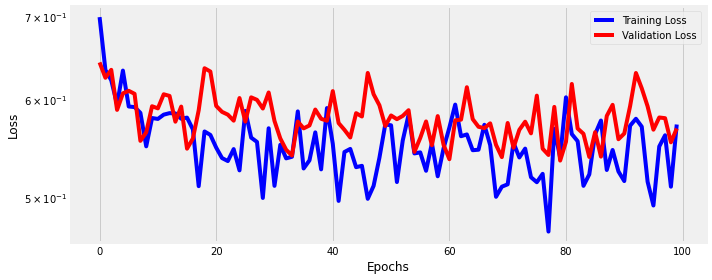

In [54]:
fig = sbs_logistic.plot_losses()

## Deep-ish Model

## Model Configuration

In [55]:
lr = 0.1

torch.manual_seed(17)

model_nn = nn.Sequential()
model_nn.add_module('flatten', nn.Flatten())
model_nn.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_nn.add_module('hidden1', nn.Linear(5,3, bias=False))
model_nn.add_module('output', nn.Linear(3,1, bias=False))
model_nn.add_module('sigmoid', nn.Sigmoid())

optimizer_nn = optim.SGD(model_nn.parameters(), lr=lr)

binary_loss_fn = nn.BCELoss()

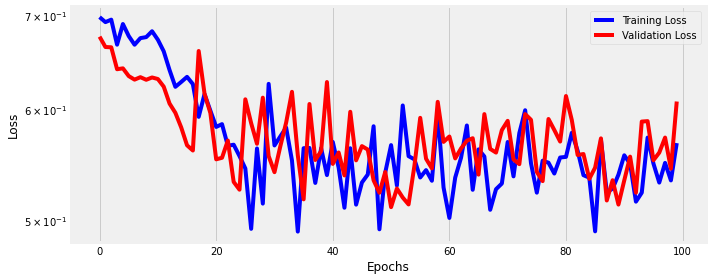

In [56]:
n_epochs = 100

sbs_nn = StepByStep(
    model_nn, binary_loss_fn, optimizer_nn
)

sbs_nn.set_loaders(train_loader, val_loader)
sbs_nn.train(n_epochs)

fig = sbs_nn.plot_losses()

In [57]:
## As we can see that deep model is not working good.
## It is not worsening, and it is also not getting better.
## Lets look at the underlying things -: Deep model w/o actiavtion function works like a linear model.

w_nn_hidden0 = model_nn.hidden0.weight.detach()
w_nn_hidden1 = model_nn.hidden1.weight.detach()
w_nn_output = model_nn.output.weight.detach()

w_nn_hidden0.shape, w_nn_hidden1.shape, w_nn_output.shape

(torch.Size([5, 25]), torch.Size([3, 5]), torch.Size([1, 3]))

In [58]:
w_nn_equiv = w_nn_output @ w_nn_hidden1 @ w_nn_hidden0
w_nn_equiv.shape

torch.Size([1, 25])

In [59]:
## We can also replace the above(@ - dot product) with torch.mm

w_nn_equiv = w_nn_output.mm(w_nn_hidden1.mm(w_nn_hidden0))

In [60]:
## Getting the shallow model weights

w_logistic_output = model_logistic.output.weight.detach()
w_logistic_output.shape


torch.Size([1, 25])

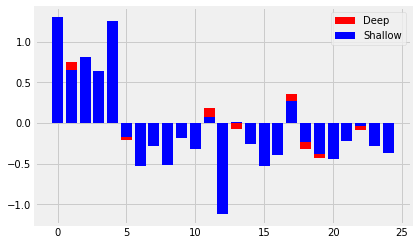

In [61]:
from matplotlib import colors
plt.bar(range(w_nn_equiv.shape[1]) ,w_nn_equiv[0].cpu().detach().numpy(), color='r')
plt.bar(range(w_logistic_output.shape[1]) ,w_logistic_output[0].cpu().detach().numpy(), color='b')
# plt.show()
plt.legend(["Deep", "Shallow"])
plt.show()

In [62]:
# w_nn_equiv[0].cpu().detach().numpy()

## Count Parameters

In [63]:
def count_parameters(self):
  return sum(p.numel()
              for p in self.model.parameters()
              if p.requires_grad)
  
setattr(StepByStep, 'count_parameters', count_parameters)

In [64]:
sbs_logistic.count_parameters(), sbs_nn.count_parameters()

(25, 143)

## Weights as pixels

In [65]:
w_nn_hidden0.shape

torch.Size([5, 25])

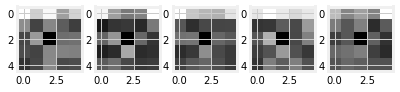

In [66]:
for i in range(w_nn_hidden0.shape[0]):
  plt.subplot(1, 5, i+1)
  # plt.figure(figsize=(10,10))
  plt.imshow(w_nn_hidden0[i].reshape((5,5)), cmap='gray')

## Activation Functions

In [67]:
## Very good Point.
## Also, remember that the activation values of any given layer are the inputs of the
# following layer and, given the range of the sigmoid, the activation values are going
# to be centered around 0.5, instead of zero. This means that, even if we normalize
# our inputs to feed the first layer, it will not be the case anymore for the other
# layers

## Very good question
## Ques. Why does it matter if the outputs are centered around zero or not?
## Ans. As we have seen that standardization of inputs are mandatory for to improve the performance of the gradient descent.
## Same applies here, author said that will touch this topic again later.



## Sigmoid

In [68]:
## Sigmoid

## There are two ways of doing it.

dummy_z = torch.tensor([-3., 0., 3.])
torch.sigmoid(dummy_z)

## Another is to do from nn Class

nn.Sigmoid()(dummy_z)

tensor([0.0474, 0.5000, 0.9526])

## Tanh
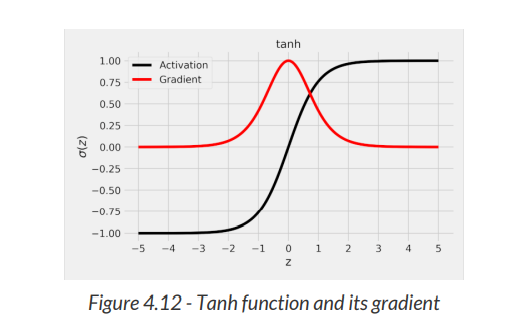

As you can see in the figure above, the tanh activation function “squashes” the
input values into the range (-1, 1). Therefore, being centered at zero, the activation
values are already (somewhat) normalized inputs for the next layer, making the
hyperbolic tangent a better activation function than the sigmoid

## ReLU

In [69]:
## There are two ways of doing it.

dummy_z = torch.tensor([-3., 0., 3.])
torch.tanh(dummy_z)

## Another is to do from nn Class

nn.Tanh()(dummy_z)

tensor([-0.9951,  0.0000,  0.9951])

In [70]:
dummy_z = torch.tensor([-3., 0., 3.])
F.relu(dummy_z)

tensor([0., 0., 3.])

In [71]:
nn.ReLU()(dummy_z)

tensor([0., 0., 3.])

In [73]:
dummy_z.clamp(min=0)

tensor([0., 0., 3.])

### Leaky ReLU

In [74]:
F.leaky_relu(dummy_z, negative_slope=0.01)

tensor([-0.0300,  0.0000,  3.0000])

In [75]:
nn.LeakyReLU(negative_slope=0.02)(dummy_z)

tensor([-0.0600,  0.0000,  3.0000])

Can we train this little negative slope, yes we can.?

## Parameteric ReLU

In [77]:
dummy_z = torch.tensor([-3., 0., 3.])
F.prelu(dummy_z, weight=torch.tensor(0.25))

## In general it doesnt make sense to set this second parameter as Prelu is going to learn it.

tensor([-0.7500,  0.0000,  3.0000])

In [78]:
nn.PReLU(init=0.25)(dummy_z)

tensor([-0.7500,  0.0000,  3.0000], grad_fn=<PreluBackward0>)

## Deep Model with Activation Functions


## Model Configuration

In [79]:
lr =0.1

torch.manual_seed(17)

model_relu = nn.Sequential()
model_relu.add_module('flatten', nn.Flatten())
model_relu.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_relu.add_module('activation0', nn.ReLU())
model_relu.add_module('hidden1', nn.Linear(5,3,bias=False))
model_relu.add_module('actiavtion1', nn.ReLU())
model_relu.add_module('output', nn.Linear(3,1, bias=False))
model_relu.add_module('sigmoid', nn.Sigmoid())

optimizer_relu = optim.SGD(model_relu.parameters(), lr=lr)
binary_loss_fn = nn.BCELoss()

## Model Training

In [80]:
n_epochs = 50

sbs_relu = StepByStep(model_relu, binary_loss_fn, optimizer_relu)
sbs_relu.set_loaders(train_loader, val_loader)
sbs_relu.train(n_epochs)

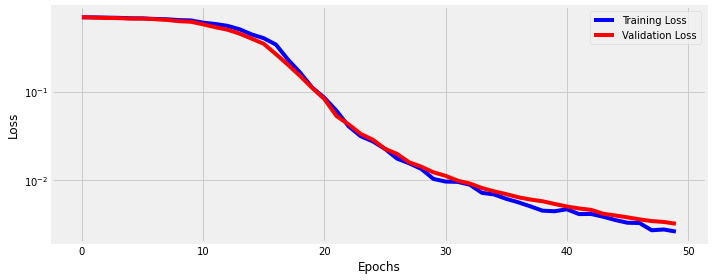

In [81]:
fig = sbs_relu.plot_losses()

## Putting it all together
We have seen the data preparation, compose data transformation, splitting the data, activation functions